In [1]:
import dalex as dx
import xgboost
import lime

import sklearn

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import platform
print(f'Python {platform.python_version()}')

Python 3.11.5


In [2]:
# !pip uninstall dalex
# !pip install dalex==1.5.0
# !conda list lime

# !pip uninstall xgboost
# !pip install xgboost xgboost=1.6.2

In [3]:
{package.__name__: package.__version__ for package in [dx, xgboost, sklearn, pd, np]} | {lime.__name__: "0.2.0.1"}

{'dalex': '1.5.0',
 'xgboost': '2.0.0',
 'sklearn': '1.3.1',
 'pandas': '1.5.3',
 'numpy': '1.26.0',
 'lime': '0.2.0.1'}

In [8]:
# !pip uninstall pandas

In [10]:
# !pip install pandas==1.5.3

In [5]:
# !conda list pandas


1. Load and preprocess data

lime.lime_tabular.LimeTabularExplainer assumes integer-encoded categorical variables by the following parameters:

    categorical_features – list of indices (ints) corresponding to the categorical columns. Everything else will be considered continuous. Values in these columns MUST be integers.

    categorical_names – map from int to list of names, where categorical_names[x][y] represents the name of the yth value of column x.

But, XGBoost assumes categorical variables of strict category type.

The challenge is to make one work with the other. First, let's use one-hot encoding.


In [6]:
df = dx.datasets.load_titanic()

X = df.drop(columns='survived')
X = pd.get_dummies(X, columns=['gender', 'class', 'embarked'], drop_first=True) 
y = df.survived


2. Model

We use the same XGBoost classifier as in the previous materials towards Homework 2.

In [7]:
model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss",
    enable_categorical=True
)

model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

3. Explain with dalex & lime

dalex uses the original lime package to estimate LIME under a unified API.

dalex aims to improve the user's conveninence by:

    combining the use of LimeTabularExplainer and explain_instance() into the one predict_surrogate() method,
    automatically setting some of the lime parameters based on explainer.data, explainer.model_type etc.

In [8]:
explainer = dx.Explainer(model, X, y)

Preparation of a new explainer is initiated

  -> data              : 2207 rows 14 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2207 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000211817C6E80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 8.26e-05, mean = 0.322, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.815, mean = -3.39e-05, max = 0.966
  -> model_info        : package xgboost

A new explainer has been created!


In [9]:
# Check performance on train data
explainer.model_performance(cutoff=y.mean())

,recall,precision,f1,accuracy,auc
XGBClassifier,0.774965,0.828571,0.800872,0.87585,0.942158


In [10]:
# Explain a prediction of interest

observation = X.iloc[[0]]
explainer.predict(observation)

array([0.02068235], dtype=float32)

In [12]:
observation.dtypes

age                       float64
fare                      float64
sibsp                       int64
parch                       int64
gender_male                 uint8
class_2nd                   uint8
class_3rd                   uint8
class_deck crew             uint8
class_engineering crew      uint8
class_restaurant staff      uint8
class_victualling crew      uint8
embarked_Cherbourg          uint8
embarked_Queenstown         uint8
embarked_Southampton        uint8
dtype: object

In [38]:
# lime.explain_instance
# lime.E(model, X, y)
# lime.explanation.Explanation. #(model, X, y)

from lime import explain_instance


ImportError: cannot import name 'explain_instance' from 'lime' (C:\Users\laptop\anaconda3\envs\xai\Lib\site-packages\lime\__init__.py)

In [23]:
observation

,age,fare,sibsp,parch,gender_male,class_2nd,class_3rd,class_deck crew,class_engineering crew,class_restaurant staff,class_victualling crew,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,42.0,7.11,0,0,1,0,1,0,0,0,0,0,0,1


In [14]:
explanation = explainer.predict_surrogate(observation)

# In dalex API, the estimated explanation can be accessed via the result attribute
explanation.result

,variable,effect
0,0.00 < class_3rd <= 1.00,-0.262286
1,class_victualling crew <= 0.00,0.074019
2,embarked_Cherbourg <= 0.00,-0.061717
3,embarked_Queenstown <= 0.00,0.055068
4,sibsp <= 0.00,0.053254
5,0.00 < fare <= 7.15,0.053137
6,class_restaurant staff <= 0.00,0.043049
7,class_deck crew <= 0.00,-0.027352
8,class_2nd <= 0.00,0.016171
9,class_engineering crew <= 0.00,0.012388


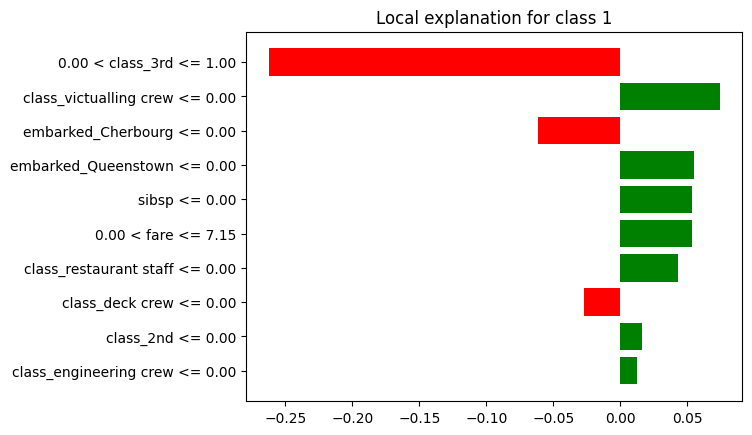

In [25]:
# Analogously, the estimated explanation can be visualized using the plot() method, which uses as_pyplot_figure() from lime
explanation.plot()

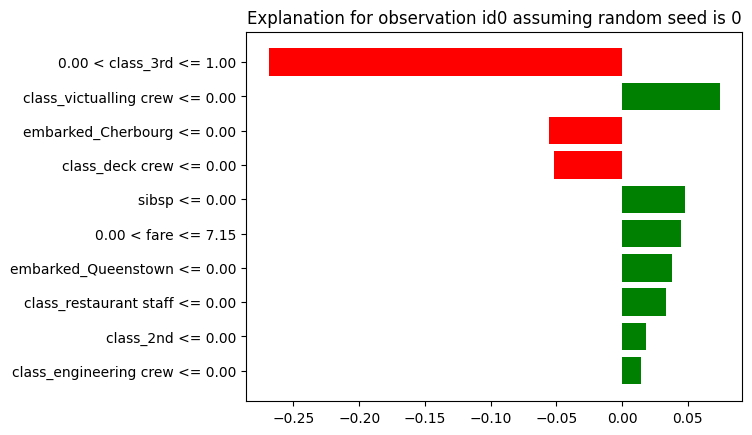

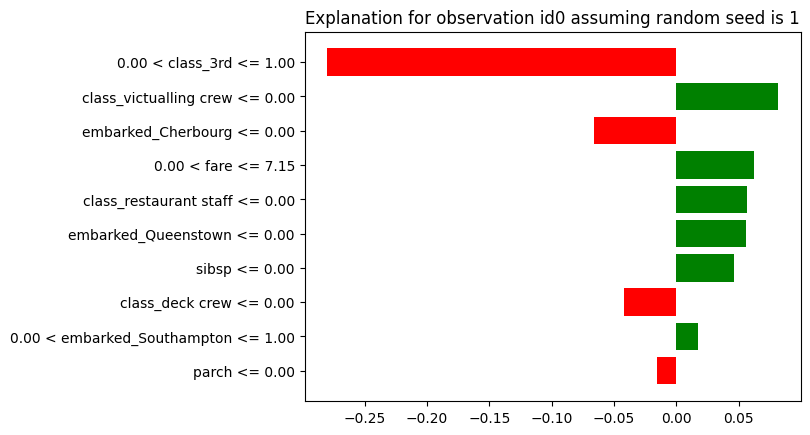

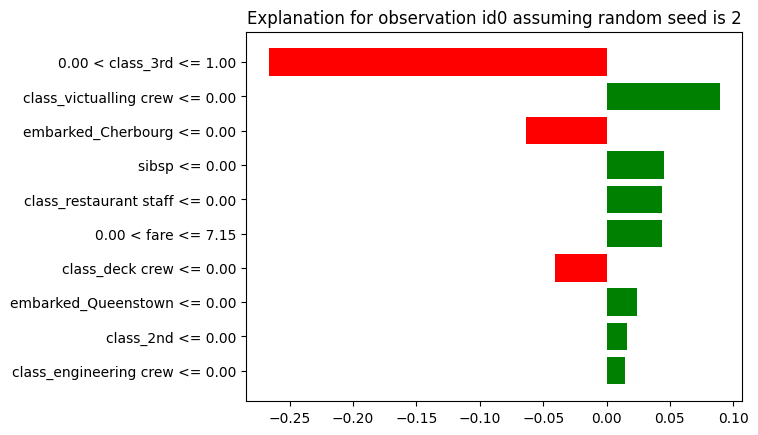

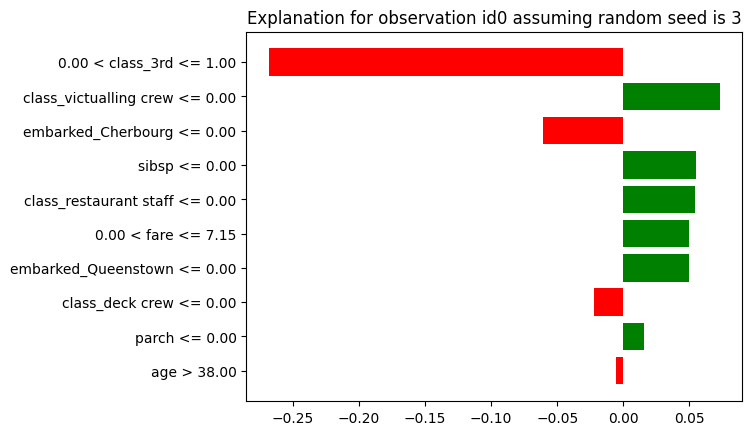

In [26]:
# Be careful! LIME algorithm, like many other explanations, involves randomness

import random
import matplotlib.pyplot as plt

for seed in range(4):
    random.seed(seed)
    np.random.seed(seed)
    exp = explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    plt.title(f'Explanation for observation id0 assuming random seed is {seed}')

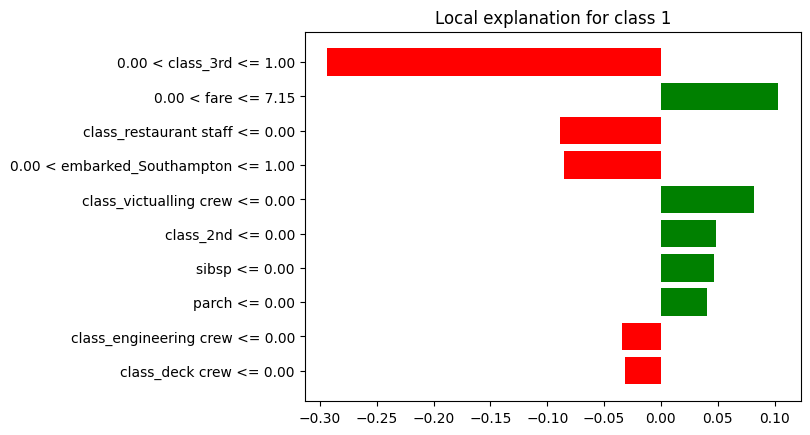

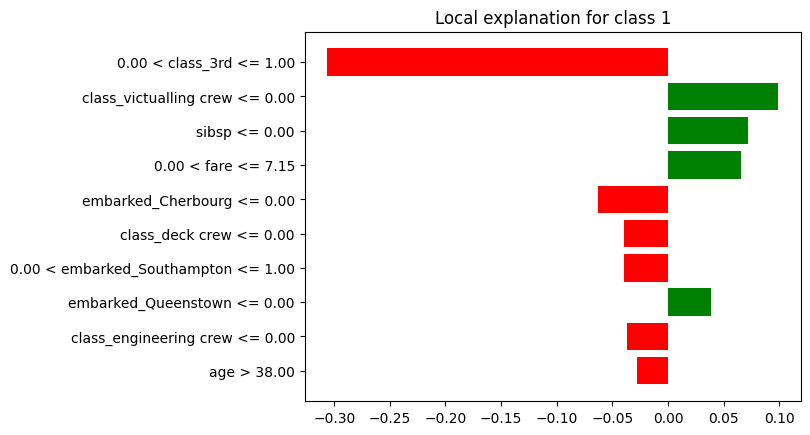

In [27]:
# Both LimeTabularExplainer and explain_instance() have many parameters, which can be jointly passed to the predict_surrogate() interface

random.seed(0)
np.random.seed(0)
exp_manhattan = explainer.predict_surrogate(observation, num_samples=1000, distance_metric="manhattan", kernel_width=1)
random.seed(0)
np.random.seed(0)
exp_euclidean = explainer.predict_surrogate(observation, num_samples=1000, distance_metric="euclidean", kernel_width=1)
exp_manhattan.plot()
exp_euclidean.plot()

In [28]:
# 4. Explain with lime

# An example of the same process using the lime package
# Note that training_data needs to be of numpy class

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,  
    feature_names=X.columns,
    mode="classification"
)

lime_explanation = lime_explainer.explain_instance(
    data_row=observation.iloc[0],
    predict_fn=lambda d: model.predict_proba(d)
)   

lime_explanation.as_list()

[('0.00 < class_3rd <= 1.00', -0.2637440061273613),
 ('class_victualling crew <= 0.00', 0.08635581940299647),
 ('embarked_Cherbourg <= 0.00', -0.06049237175068497),
 ('0.00 < fare <= 7.15', 0.05887433813055477),
 ('class_restaurant staff <= 0.00', 0.046153409535065894),
 ('class_deck crew <= 0.00', -0.045621433259522996),
 ('sibsp <= 0.00', 0.040325731113060204),
 ('class_2nd <= 0.00', 0.021113659748761074),
 ('embarked_Queenstown <= 0.00', 0.0193634790365608),
 ('parch <= 0.00', -0.011461891018138971)]

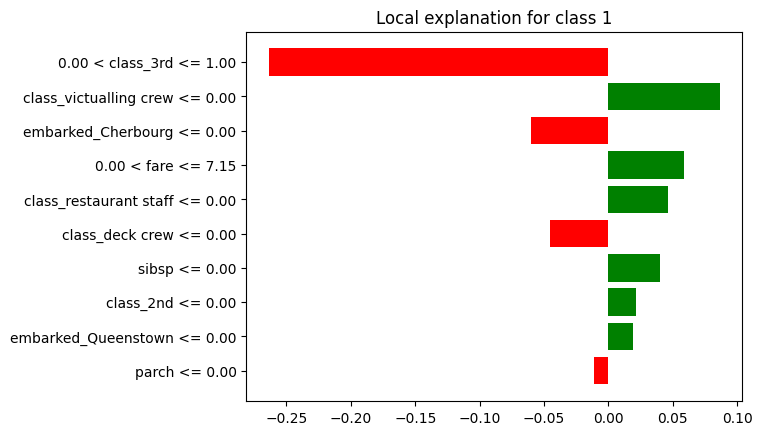

In [29]:
_ = lime_explanation.as_pyplot_figure()

In [30]:
_ = lime_explanation.show_in_notebook()

In [31]:
# Now, let's try combining categorical encoding in xgboost with an integer encoding in lime.
# We start by creating two datasets of different type

# convert gender to binary only because the `max_cat_to_onehot` parameter in XGBoost is yet to be working properly..

X_cat = pd.get_dummies(df.drop(columns='survived'), columns=["gender"], drop_first=True)
X_fact = pd.get_dummies(df.drop(columns='survived'), columns=["gender"], drop_first=True)

X_cat.loc[:, X_cat.dtypes == 'object'] =\
    X_cat.select_dtypes(['object'])\
    .apply(lambda x: x.astype('category'))

X_fact.loc[:, X_fact.dtypes == 'object'] =\
    X_cat.select_dtypes(['category'])\
        .apply(lambda x: x.cat.codes)

y = df.survived

# We use the first dataset to model

model_categorical = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)

model_categorical.fit(X_cat, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [32]:
# We use the second dataset to explain

categorical_features = [1, 2]
categorical_names = {id: X_cat.iloc[:, id].cat.categories for id in categorical_features}

print(categorical_names)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_fact.values,  
    feature_names=X_fact.columns,
    mode="classification",
    categorical_features=categorical_features,
    categorical_names=categorical_names
)

{1: Index(['1st', '2nd', '3rd', 'deck crew', 'engineering crew',
       'restaurant staff', 'victualling crew'],
      dtype='object'), 2: Index(['Belfast', 'Cherbourg', 'Queenstown', 'Southampton'], dtype='object')}


In [33]:
lime_explanation = lime_explainer.explain_instance(
    data_row=X_fact.values[0],
    predict_fn=lambda d: model_categorical.predict_proba(d)
)   

lime_explanation.as_list()

[('class=3rd', -0.2105915438247798),
 ('0.00 < fare <= 7.15', 0.08842874637929003),
 ('age > 38.00', -0.06484781993305928),
 ('sibsp <= 0.00', 0.05501068746284125),
 ('parch <= 0.00', 0.006984664314178392),
 ('embarked=Southampton', 0.005582967777701968),
 ('gender_male <= 1.00', 0.0)]

In [34]:
lime_explanation.show_in_notebook()

In [35]:
# Note that XGBoost allows predicting on both datasets without returning any error..

(model_categorical.predict_proba(X_cat) == model_categorical.predict_proba(X_fact)).mean()

1.0

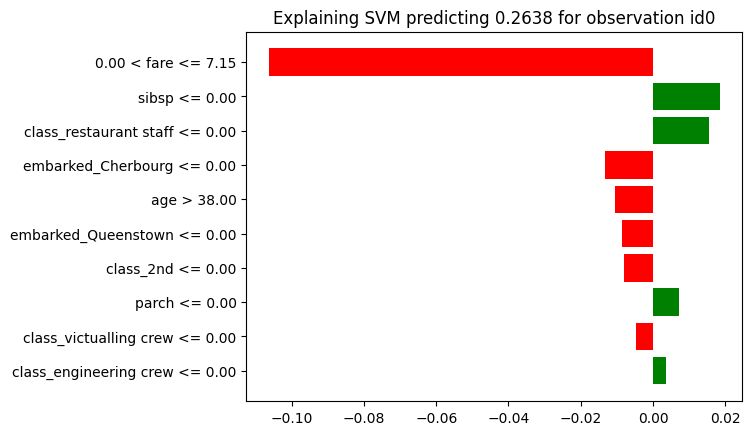

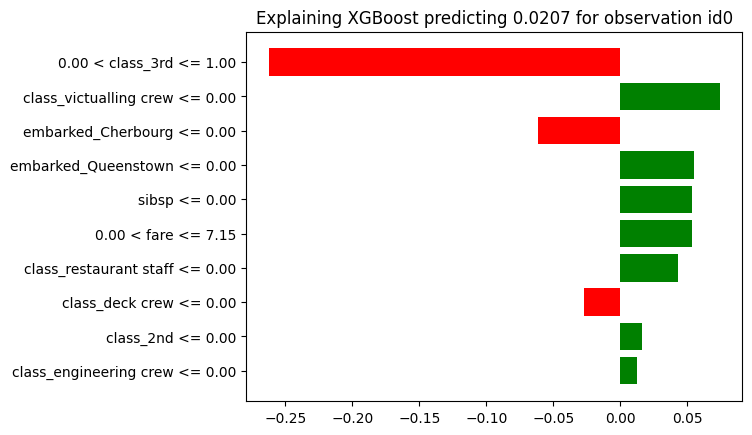

In [37]:
# 5. Compare with SVM

# Working with other models is similar in both packages; the key is a proper predict_function in dalex and predict_fn in lime

from sklearn.svm import SVC

svm_ohe = SVC(probability=True)

svm_ohe.fit(X, y)

explainer_svm = dx.Explainer(svm_ohe, X, label="SVM", verbose=False)

explanation_svm = explainer_svm.predict_surrogate(observation)

# Compare predictions and their explanations

explanation_svm.plot(return_figure=True)
_ = plt.title(f'Explaining SVM predicting {np.round(explainer_svm.predict(observation).item(), 4)} for observation id0')

explanation.plot(return_figure=True)
_ = plt.title(f'Explaining XGBoost predicting {np.round(explainer.predict(observation).item(), 4)} for observation id0')

## https://ema.drwhy.ai